In [1]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
from sys import stdout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
%matplotlib inline

# Dinâmica Molecular usando OpenMM

https://openmm.org/

## Instalando o OpenMM

In [2]:
## Primeira opção usando conda
# !conda install -c conda-forge openmm mdtraj nglview
# pip install openmm mdtraj nglview

## Importando a Biblioteca

In [3]:
import mdtraj
import nglview

from openmm.app import *
from openmm import *
from openmm.unit import *

## Input com posição das partículas

In [4]:
xyz_data = pd.read_csv('../data/positions-N=864-rho=0.840-kT=0.710.xyz',sep='\t',skiprows=2,names=['x','y','z'])

In [5]:
xyz_data

,x,y,z
0,9.50185,9.41310,6.58248
1,1.60217,1.90719,7.76761
2,9.16342,1.03461,8.71883
3,0.75624,1.66058,9.44078
4,6.96636,9.71882,4.82582
...,...,...,...
859,8.42259,1.89441,1.32876
860,7.71757,8.58243,8.21504
861,8.86400,8.68088,1.87669
862,0.66307,6.66686,4.02066


Criando array com posições

In [6]:
initial_positions = xyz_data[['x','y','z']].values / 11.0

Número total de partículas

In [7]:
N_atoms = initial_positions.shape[0]

Posição da partícula 0

In [8]:
initial_positions[0]

array([0.86380455, 0.85573636, 0.59840727])

Gráfico das posições em $x$ e $y$

Text(0, 0.5, 'y')

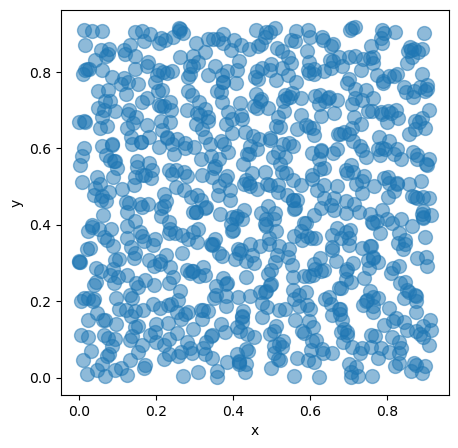

In [9]:
plt.figure(figsize=(5,5))
plt.plot(initial_positions[:,0],initial_positions[:,1],'o',ms=10.0,alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')

## Simulação NVE no OpenMM

Variáveis das partículas de LJ (no caso Argônio)

In [10]:
# Parâmetros físicos do argônio
epsilon = 117.8 * kelvin * BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA
sigma = 3.419 * angstrom
mass = 39.948 * amu

# Parâmetros da simulação 
cutoff = 2.5*sigma

print(epsilon)

979.4436964184517 J/mol


Condição termodinâmica

In [11]:
rho = 0.84/sigma**3

print(rho)

0.021017544890034698 /(A**3)


Tamanho da caixa

In [12]:
L = (N_atoms/rho)**(1/3)

print(L)

34.512566219789825 A


`system`: número de partículas e suas massas, vetores da célula (caixa de simulação)

In [13]:
system = System()
for i in range(N_atoms):
    system.addParticle(mass)

In [14]:
box_matrix = L * np.identity(3)
system.setDefaultPeriodicBoxVectors(*box_matrix)

Qual o número de partículas?

In [15]:
system.getNumParticles()

864

`topology`: identifica os átomos e informações relacionadas: ligações química, resíduos e cadeias.

Todos os átomos de argônio são agrupados em um resíduo e uma cadeia. Essa informação é necessária para escrever arquivos PDB.

In [16]:
# Define a relatively boring topology object.
topology = Topology()
topology.setPeriodicBoxVectors(box_matrix)
chain = topology.addChain()
residue = topology.addResidue("argon", chain)
element_Ar = Element.getByAtomicNumber(18)
for _iatom in range(N_atoms):
    topology.addAtom("Ar", element_Ar, residue)

`force`: define qual o topo de interação modificará as velocidades e as posições das partículas

- existem campos de força já definidos ou usuário pode criar
- adiciona essa info ao sistema

In [17]:
energy = '4*epsilon*((sigma/r)^12-(sigma/r)^6); sigma=(sigma1+sigma2)/2; epsilon=sqrt(epsilon1*epsilon2)'
force = CustomNonbondedForce(energy)
force.addPerParticleParameter('sigma')
force.addPerParticleParameter('epsilon')
for i in range(N_atoms):
    force.addParticle([sigma,epsilon])
force.setCutoffDistance(cutoff)
force.setNonbondedMethod(force.CutoffPeriodic)
force_index = system.addForce(force)

`integrator`: define o integrador a ser utilizado (Verlet para NVE)

In [18]:
dt = 3 * femtoseconds # (10^-15 s)
integrator = VerletIntegrator(dt)

`platform`: define qual plataforma usar (CPU, CUDA)

In [19]:
platform = Platform.getPlatformByName('CPU')

`simulation`: une a topologia, sistema, integrador e a plataforma. Contem todas as informações do estado do sistema: posições, velocidades, outros parametros

In [20]:
# Define um objeto de simulação
simulation = Simulation(topology, system, integrator, platform,)

# Inicializa as posições iniciais
simulation.context.setPositions(initial_positions * L)

# Inicializa velocidades com valores aleatórios à temperatura de 300K.
simulation.context.setVelocitiesToTemperature(300 * kelvin)

`state`: uma fotografia do estado do sistema. Necessário para acessar as posições, energias e forças

In [21]:
state = simulation.context.getState(getEnergy=True, getForces=True)

Energia Potencial Inicial

In [22]:
state.getPotentialEnergy()

Quantity(value=-2000.886305809021, unit=kilojoule/mole)

Energia Cinética Inicial

In [23]:
state.getKineticEnergy()

Quantity(value=3217.409223225238, unit=kilojoule/mole)

Força sobre uma partícula

In [24]:
state.getForces()[0]

Quantity(value=Vec3(x=139.60711669921875, y=-12.410024642944336, z=114.98684692382812), unit=kilojoule/(nanometer*mole))

A célula seguinte define todos os reporters e realiza a simulação de MD

In [25]:
# Remove reporters existentes, no caso dessa célula ser executada mais de uma vez.
simulation.reporters = []

# Escreve a geometria inicial com um arquivo PDB
positions = simulation.context.getState(getPositions=True).getPositions()
with open("ljinit.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, positions, f)

# Escreve cada frame em arquivo DCD de trajetórias a cada 1000 passos
simulation.reporters.append(DCDReporter("ljtraj.dcd", 1000))

# Escreve num arquivo csv a cada 100 passos 
simulation.reporters.append(
    StateDataReporter(
        "ljscalars.csv",
        10,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True
    )
)

# Escreve na tela a cada 1000 passos 
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True)
)

# Roda a simulação molecular com 40000 passos
simulation.step(40000)

# A próxima linha é necessária para Windows para fechar os arquivos antes de serem abertos
del simulation

#"Step","Temperature (K)"
1000,393.3849091421561
2000,385.7479018981585
3000,390.1683499350928
4000,379.28656768893137
5000,396.25315259485916
6000,393.25759280823735
7000,387.19060596641276
8000,387.6297342295546
9000,394.084493649496
10000,387.9147197433108
11000,385.5101923382636
12000,389.58516903119965
13000,397.9734945816711
14000,398.25782751789177
15000,388.5219978683736
16000,399.4049108834925
17000,385.0404708024208
18000,383.5727322562827
19000,388.53944317125627
20000,394.7178799438269
21000,394.25894998051587
22000,390.9891323869633
23000,385.1126110302193
24000,388.8112695904908
25000,390.8914470019889
26000,392.8111745315599
27000,385.4135397320023
28000,395.78587904703653
29000,388.45635987248306
30000,394.5194771615314
31000,380.27638785649066
32000,380.91791084818783
33000,385.63924352161047
34000,393.64522695803197
35000,391.31705504626757
36000,396.80764303504884
37000,381.97493278836663
38000,384.2829872313748
39000,385.80409057406536
40000,377.94921500667186


### Análise dos dados

In [44]:
traj = mdtraj.load("ljtraj.dcd", top="ljinit.pdb")
view = nglview.show_mdtraj(traj)
view.add_unitcell()
view.layout = {'width': '50%'}
view.handle_resize()
view

NGLWidget(layout=Layout(width='50%'), max_frame=39)

In [27]:
df = pd.read_csv("ljscalars.csv")

In [28]:
df.head()

,"#""Step""",Time (ps),Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K)
0,10,0.03,-2169.203574,1216.887146,314.238507
1,20,0.06,-2290.078803,1216.453558,325.415822
2,30,0.09,-2479.686613,1216.940875,343.057171
3,40,0.12,-2715.207230,1215.879182,364.815602
4,50,0.15,-2844.329302,1216.094725,376.818488


In [29]:
df['Total Energy (kJ/mole)']

0       1216.887146
1       1216.453558
2       1216.940875
3       1215.879182
4       1216.094725
           ...     
3995    1227.011864
3996    1227.081299
3997    1227.327029
3998    1227.158592
3999    1228.556820
Name: Total Energy (kJ/mole), Length: 4000, dtype: float64

Text(0, 0.5, 'T (K)')

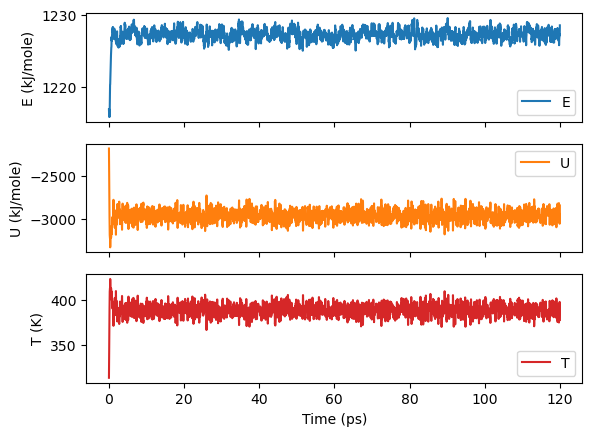

In [30]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(df['Time (ps)'],df['Total Energy (kJ/mole)'],label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel('E (kJ/mole)')

axs[1].plot(df['Time (ps)'],df['Potential Energy (kJ/mole)'],color='C1',label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel('U (kJ/mole)')

axs[2].plot(df['Time (ps)'],df['Temperature (K)'],color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time (ps)')
axs[2].set_ylabel('T (K)')

In [31]:
df['Temperature (K)'][df['Time (ps)'] > 10]

333     388.524378
334     389.684809
335     393.988922
336     402.601052
337     396.701159
           ...    
3995    394.000483
3996    396.752108
3997    397.960448
3998    391.180008
3999    377.949215
Name: Temperature (K), Length: 3667, dtype: float64

In [32]:
subsetT = df['Temperature (K)'][df['Time (ps)'] > 10]
subsetU = df['Potential Energy (kJ/mole)'][df['Time (ps)'] > 10]

In [33]:
from IPython.display import display, Math

Umean = subsetU.mean()
sigmaU = subsetU.std()

display(Math(rf"U = {Umean:.2f} \pm {sigmaU:.2f}\ kJ/mole"))

<IPython.core.display.Math object>

In [34]:
Tmean = subsetT.mean()
sigmaT = subsetT.std()

display(Math(rf"$T = {Tmean:.2f} \pm {sigmaT:.2f}\ K"))

<IPython.core.display.Math object>

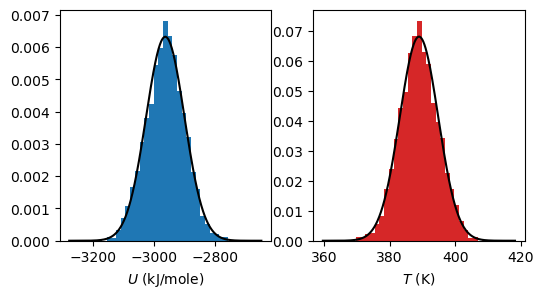

In [35]:
fig, axs = plt.subplots(1, 2,figsize=(6,3))

axs[0].hist(subsetU,bins=30,density=True)
axs[0].set_xlabel(r'$U$ (kJ/mole)')

uarray = Umean+np.arange(-5*sigmaU,5*sigmaU,0.01*sigmaU)
axs[0].plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

axs[1].hist(subsetT,bins=30,density=True,color='C3')
axs[1].set_xlabel(r'$T$ (K)')

Tarray = Tmean + np.arange(-5*sigmaT,5*sigmaT,0.01*sigmaT)
axs[1].plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

## Simulação NVT no OpenMM

In [36]:
temperature = 300 * kelvin
integrator = LangevinIntegrator(temperature, 1 / picosecond, 3 * femtoseconds)

In [37]:
# Define um objeto de simulação
simulation = Simulation(topology, system, integrator, platform,)

# Inicializa as posições iniciais
simulation.context.setPositions(initial_positions * L)

# Inicializa velocidades com valores aleatórios à temperatura de 300K.
simulation.context.setVelocitiesToTemperature(temperature)

In [38]:
# Remove reporters existentes, no caso dessa célula ser executada mais de uma vez.
simulation.reporters = []

# Escreve a geometria inicial com um arquivo PDB
positions = simulation.context.getState(getPositions=True).getPositions()
with open("ljinit.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, positions, f)

# Escreve cada frame em arquivo DCD de trajetórias a cada 1000 passos
simulation.reporters.append(DCDReporter("ljtraj.dcd", 1000))

# Escreve num arquivo csv a cada 100 passos 
simulation.reporters.append(
    StateDataReporter(
        "ljscalars.csv",
        10,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True
    )
)

# Escreve na tela a cada 1000 passos 
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True)
)

# Roda a simulação molecular com 40000 passos
simulation.step(40000)

# A próxima linha é necessária para Windows para fechar os arquivos antes de serem abertos
del simulation

#"Step","Temperature (K)"
1000,280.4953397824356
2000,289.47312857638553
3000,294.7049215687433
4000,302.44127987332956
5000,300.9925177599908
6000,302.68779944378167
7000,295.13746596786564
8000,315.2666957070896
9000,293.6007588452283
10000,275.2261998817284
11000,308.19733472783037
12000,292.13085438343
13000,306.1295879129686
14000,301.37151076038924
15000,317.943571995049
16000,308.53021100451645
17000,309.42277517035717
18000,283.1629356513402
19000,297.6523730917051
20000,299.5508619029101
21000,290.6934680857804
22000,283.19363931301814
23000,302.9474814276857
24000,291.03333841089733
25000,308.36286781119065
26000,295.4375556592654
27000,309.6797738299491
28000,296.89205548081304
29000,281.31761939438064
30000,284.1611201411732
31000,304.5403016035295
32000,309.8008185254174
33000,300.84064382094897
34000,296.40603415755385
35000,297.0697549129022
36000,308.70695249558514
37000,289.95646283963407
38000,295.8659427049372
39000,302.8651490174058
40000,307.95422534771325


### Análise dos dados 

In [45]:
traj = mdtraj.load("ljtraj.dcd", top="ljinit.pdb")
view = nglview.show_mdtraj(traj)
view.add_unitcell()
view.layout = {'width': '50%'}
view.handle_resize()
view

NGLWidget(layout=Layout(width='50%'), max_frame=39)

In [40]:
df = pd.read_csv("ljscalars.csv")

Text(0, 0.5, 'T (K)')

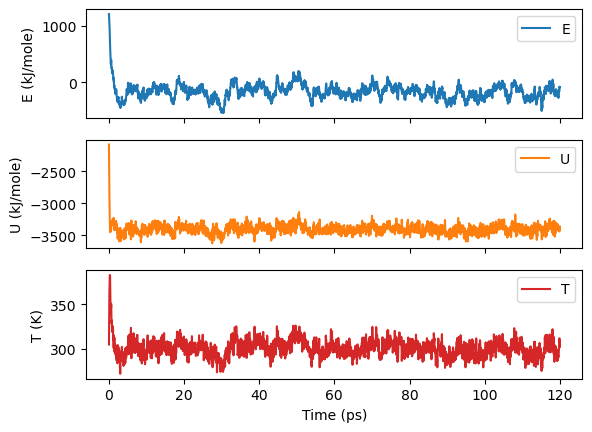

In [41]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(df['Time (ps)'],df['Total Energy (kJ/mole)'],label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel('E (kJ/mole)')

axs[1].plot(df['Time (ps)'],df['Potential Energy (kJ/mole)'],color='C1',label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel('U (kJ/mole)')

axs[2].plot(df['Time (ps)'],df['Temperature (K)'],color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time (ps)')
axs[2].set_ylabel('T (K)')

In [42]:
subsetT = df['Temperature (K)'][df['Time (ps)'] > 10]
subsetU = df['Potential Energy (kJ/mole)'][df['Time (ps)'] > 10]

# Energia Potencial
Umean = subsetU.mean()
sigmaU = subsetU.std()

display(Math(rf"U = {Umean:.2f} \pm {sigmaU:.2f}\ kJ/mole"))

# Temperatura
Tmean = subsetT.mean()
sigmaT = subsetT.std()

display(Math(rf"$T = {Tmean:.2f} \pm {sigmaT:.2f}\ K"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

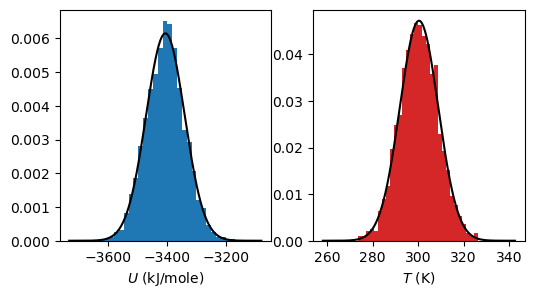

In [43]:
fig, axs = plt.subplots(1, 2,figsize=(6,3))

axs[0].hist(subsetU,bins=30,density=True)
axs[0].set_xlabel(r'$U$ (kJ/mole)')

uarray = Umean+np.arange(-5*sigmaU,5*sigmaU,0.01*sigmaU)
axs[0].plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

axs[1].hist(subsetT,bins=30,density=True,color='C3')
axs[1].set_xlabel(r'$T$ (K)')

Tarray = Tmean + np.arange(-5*sigmaT,5*sigmaT,0.01*sigmaT)
axs[1].plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> - Calcule g(r) para esse caso;
> - Baixe a temperatura para $k_B T /\epsilon = 1.0$ e aumente a densidade para $\rho \sigma^3 = 1.2$ 
>